In [1]:
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

import awkward as ak
import sys
sys.path.insert(0,"../")

from coffea.nanoevents import NanoEventsFactory, BaseSchema

In [2]:
events = NanoEventsFactory.from_root("../WJet_CSC_ABCDskim.root",treepath="MuonSystem",schemaclass=BaseSchema).events()

In [3]:
events.fields

['ncluster',
 'cluster_time',
 'cluster_size',
 'cluster_timeSpread',
 'cluster_eta',
 'cluster_phi',
 'cluster_x',
 'cluster_y',
 'cluster_z',
 'cluster_llp_x',
 'cluster_llp_y',
 'cluster_llp_z',
 'cluster_NChamber',
 'cluster_MaxChamber',
 'cluster_MaxStation',
 'cluster_NStation10',
 'cluster_AvgStation10',
 'cluster_ME11_12',
 'cluster_llp_match',
 'cluster_RE12',
 'cluster_MB1seg',
 'cluster_RB1',
 'cluster_dphi_cluster_MET',
 'cluster_dphi_cluster_lep',
 'cluster_dr_cluster_lep',
 'ndt_cluster',
 'dt_cluster_size',
 'dt_cluster_x',
 'dt_cluster_y',
 'dt_cluster_z',
 'dt_cluster_llp_x',
 'dt_cluster_llp_y',
 'dt_cluster_llp_z',
 'dt_cluster_llp_match',
 'dt_cluster_eta',
 'dt_cluster_phi',
 'dt_cluster_JetVetoPt',
 'dt_cluster_MuonVetoPt',
 'dt_cluster_NStation10',
 'dt_cluster_AvgStation10',
 'dt_cluster_MaxStation',
 'dt_cluster_nRPC',
 'dt_cluster_nMB1_cosmic_minus',
 'dt_cluster_nMB1_cosmic_plus',
 'dt_cluster_nMB1',
 'dt_cluster_rpcBx',
 'dt_cluster_dphi_cluster_MET',
 'dt_c

In [4]:
events.cluster_time

<Array [[-24.1, -0.36], ... 12.5], [-1.21]] type='423 * var * float32[parameters...'>

In [5]:
cls = ak.zip(
    {k.replace("cluster_",""):getattr(events,k) for k in events.fields if k.startswith("cluster_")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )
dt_cls = ak.zip(
    {k.replace("dt_cluster_",""):getattr(events,k) for k in events.fields if k.startswith("dt_cluster_")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior    
)
gen = ak.zip({k.replace("gParticle_","").lower():getattr(events,k) for k in events.fields if k.startswith("gParticle_")})

# Prune gen particles

In [162]:
## TODO: use particle package to convert pdgIDs
##  python -m pip install particle
## https://github.com/scikit-hep/particle

In [69]:
import particle
from particle import Particle

In [6]:
## Unique gen particles status
np.unique(ak.flatten(gen.status)).to_list()

[1,
 2,
 4,
 21,
 22,
 23,
 31,
 33,
 41,
 42,
 43,
 44,
 51,
 52,
 53,
 61,
 62,
 63,
 71,
 72,
 73,
 74,
 91]

In [7]:
## Unique gen particles ID with status ==1
np.unique(np.abs(ak.flatten(gen[gen.status==1].id))).to_list()

[11,
 12,
 13,
 14,
 16,
 22,
 130,
 211,
 310,
 321,
 2112,
 2212,
 3112,
 3122,
 3222,
 3312,
 3322,
 3334]

In [8]:
gen = gen[gen.status==1]

## Compute all cls-gen pairs 
-  This is a doubly-jagged array i.e. need 3 indices for each elemnt: [event][cls][gen]
-  p.s. Putting "cls" first in ak.cartesian means 2nd index will be cls

In [9]:
cls_gen_pairs = ak.cartesian({"cls":cls,"gen":gen},axis=1,nested=True)

In [10]:
# first event has 2 clusters and 1192 gen particles
print("Number of clusters in first event = ",len(cls[0]))
print("Number of gParticles in first event = ",len(gen[0]))
print("Number of pairs of 2nd clusters in the first event = ",len(cls_gen_pairs[0][1]))

Number of clusters in first event =  2
Number of gParticles in first event =  418
Number of pairs of 2nd clusters in the first event =  418


In [62]:
def Unique(arr):
    return np.unique(ak.flatten(arr,None))

In [11]:
# comput all delta R between all pairs
delta_R = cls_gen_pairs.cls.delta_r(cls_gen_pairs.gen)

In [92]:
matched_gen = cls_gen_pairs.gen[delta_R<0.4]
matched_cls = cls_gen_pairs.cls[delta_R<0.4]

In [94]:
ak.num(cls_gen_pairs.gen[delta_R<0.4],axis=2)

<Array [[5, 1], [6], [2], ... [1], [1], [1]] type='423 * var * int64'>

In [88]:
## List of all stable particles 
[(Particle.from_pdgid(i).name,i) for i in Unique(abs(gen.id)).to_list()]

[('e-', 11),
 ('nu(e)', 12),
 ('mu-', 13),
 ('nu(mu)', 14),
 ('nu(tau)', 16),
 ('gamma', 22),
 ('K(L)0', 130),
 ('pi+', 211),
 ('K(S)0', 310),
 ('K+', 321),
 ('n', 2112),
 ('p', 2212),
 ('Sigma-', 3112),
 ('Lambda', 3122),
 ('Sigma+', 3222),
 ('Xi-', 3312),
 ('Xi0', 3322),
 ('Omega-', 3334)]

In [175]:
np.unique(ak.flatten(np.abs(matched_gen.id),axis=None)).to_list()

[11, 13, 22, 130, 211, 310, 321, 2112, 2212]

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

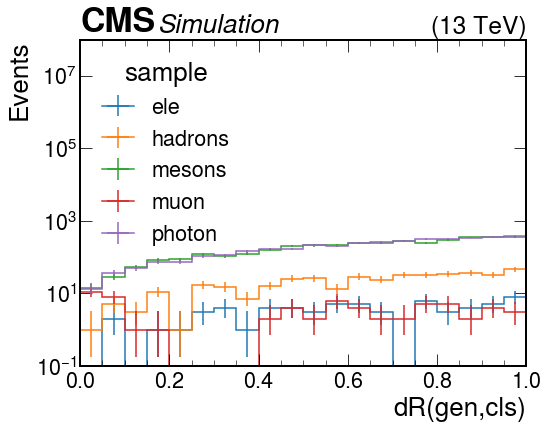

In [87]:
mesons = np.logical_and(abs(cls_gen_pairs.gen.id)>100,abs(cls_gen_pairs.gen.id)<1000) 
hadrons = np.logical_and(abs(cls_gen_pairs.gen.id)>1000,abs(cls_gen_pairs.gen.id)<10000) 

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h = hist.Hist("Events",
         hist.Cat("sample","sample"),
         hist.Bin("dR","dR(gen,cls)",20,0,1))

h.fill(sample="ele",dR=ak.flatten(delta_R[abs(cls_gen_pairs.gen.id)==11],None))
h.fill(sample="muon",dR=ak.flatten(delta_R[abs(cls_gen_pairs.gen.id)==13],None))
h.fill(sample="photon",dR=ak.flatten(delta_R[cls_gen_pairs.gen.id==22],None))
h.fill(sample="mesons",dR=ak.flatten(delta_R[mesons],None))
h.fill(sample="hadrons",dR=ak.flatten(delta_R[hadrons],None))
hist.plot1d(h,ax=axs)
axs.set_yscale("log")
axs.set_ylim(1e-1,1e8)

hep.cms.label(ax=axs)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

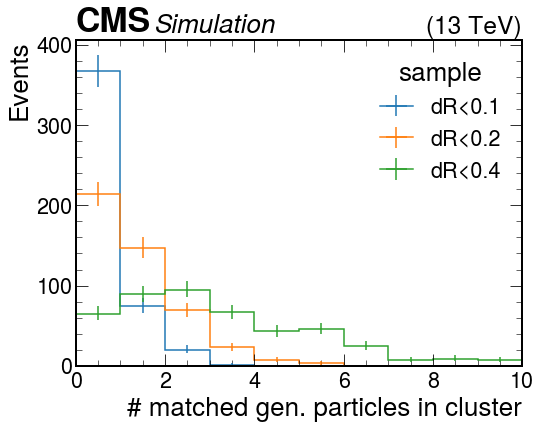

In [99]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h = hist.Hist("Events",
         hist.Cat("sample","sample"),
         hist.Bin("nMatched","# matched gen. particles in cluster",10,0,10))
h.fill(sample="dR<0.4",nMatched=ak.flatten(ak.num(cls_gen_pairs.gen[delta_R<0.4],axis=2),None))
h.fill(sample="dR<0.2",nMatched=ak.flatten(ak.num(cls_gen_pairs.gen[delta_R<0.2],axis=2),None))
h.fill(sample="dR<0.1",nMatched=ak.flatten(ak.num(cls_gen_pairs.gen[delta_R<0.1],axis=2),None))
hist.plot1d(h,ax=axs)
hep.cms.label(ax=axs)

In [220]:
ak.flatten(,None)

<Array [False, True, True, ... False, False] type='118 * bool'>

In [210]:
abs(matched_gen.id)>100 

<Array [[[], []], [[False], ... [[]], [[]]] type='423 * var * var * bool'>

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

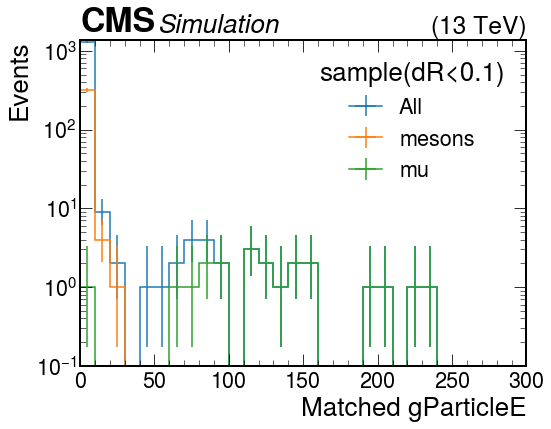

In [168]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))

h = hist.Hist("Events",
         hist.Cat("sample","sample(dR<0.1)"),
         hist.Bin("E","Matched gParticleE",30,0,300))
h.fill(sample="All",E=ak.flatten(matched_gen.e,axis=None))
h.fill(sample="mu",E=ak.flatten(matched_gen[abs(matched_gen.id)==13].e,axis=None))
mesons = np.logical_and(matched_gen.id>100,matched_gen.id<1000)
h.fill(sample="mesons",E=ak.flatten(matched_gen[mesons].e,axis=None))
hist.plot1d(h,ax=axs)
axs.set_yscale("log")
axs.set_ylim(1e-1,None)
hep.cms.label(ax=axs)


In [199]:
ak.flatten(matched_gen[matched_gen.id==11].e,axis=None)

<Array [0.535] type='1 * float32'>

In [35]:
matched_gen[1].to_listst()

[[{'e': 0.7284149527549744,
   'eta': 1.3850864171981812,
   'phi': 2.802109956741333,
   'id': 22,
   'motherid': 111,
   'pt': 0.34314900636672974,
   'status': 1}]]

In [204]:
def display(i_event, gen,cls,e_cut=1,save=False):
#     i_event = 3
    i_cls = cls[i_event]
    i_gen = gen[i_event]

    ele   = i_gen[abs(i_gen.id)==11]
    mu    = i_gen[abs(i_gen.id)==13]
    gamma = i_gen[abs(i_gen.id)==22]
    meson = i_gen[np.logical_and(abs(i_gen.id)>100,abs(i_gen.id)<1000)]
    hadrons = i_gen[np.logical_and(abs(i_gen.id)>1000,abs(i_gen.id)<10000)]

    fig, axs = plt.subplots(1,1, figsize=(8,6))

    particles = [ele,mu,gamma,meson,hadrons]
    labels = ["e","mu","gamma","meson","hadrons"]

    axs.scatter(i_cls.eta,i_cls.phi,s=i_cls.size,label="cluster")
    for cl in i_cls:
        cone = plt.Circle((cl.eta, cl.phi), 0.4, color='b', fill=False,)
        axs.add_patch(cone)
    for i,parts in enumerate(particles):
        parts = parts[parts.e>e_cut]
        axs.scatter(parts.eta,parts.phi,s=parts.e,label=labels[i])
    axs.set_ylim(-5,5)
    axs.set_xlim(-5,5)
    axs.set_ylabel(r"$\phi$")
    axs.set_xlabel(r"$\eta$")
    axs.text(-4,4,r"$E_{gen}$>%s GeV"%e_cut,fontsize="small")
    leg = axs.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    hep.cms.label(ax=axs)    
    for l in leg.legendHandles:
        l._sizes = [30]
    if save:
        fig.savefig("eventDisplay_%s.pdf"%i_event)

In [205]:
## pick out some interesting events
np.where(ak.num(cls)==2)

(<Array [0, 21, 24, 33, ... 392, 394, 399, 407] type='38 * int64'>,)

In [208]:
np.max(ak.num(cls))

3

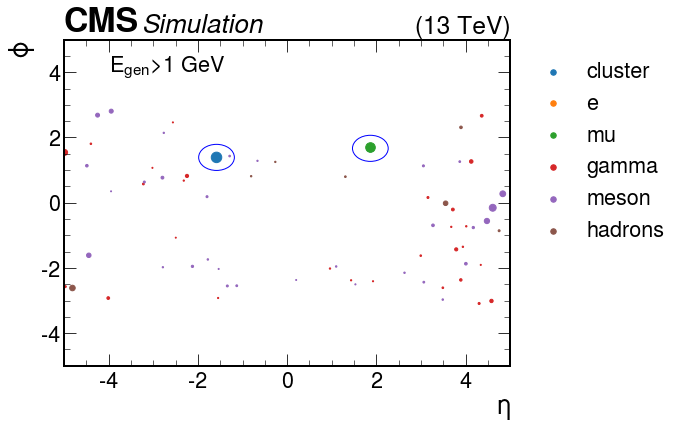

In [206]:
display(399,gen,cls)